In [32]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import folium
from folium.plugins import MarkerCluster
import warnings
import pandas as pd

In [33]:
df = pd.read_csv('Wildland_Fire_Incident_Locations.csv', low_memory=False)
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    df.columns
df = df[['X','Y','OBJECTID','DiscoveryAcres','FireCause','FireDiscoveryDateTime','GACC',
         'POOCounty','POOFips','POOState']]

<Axes: >

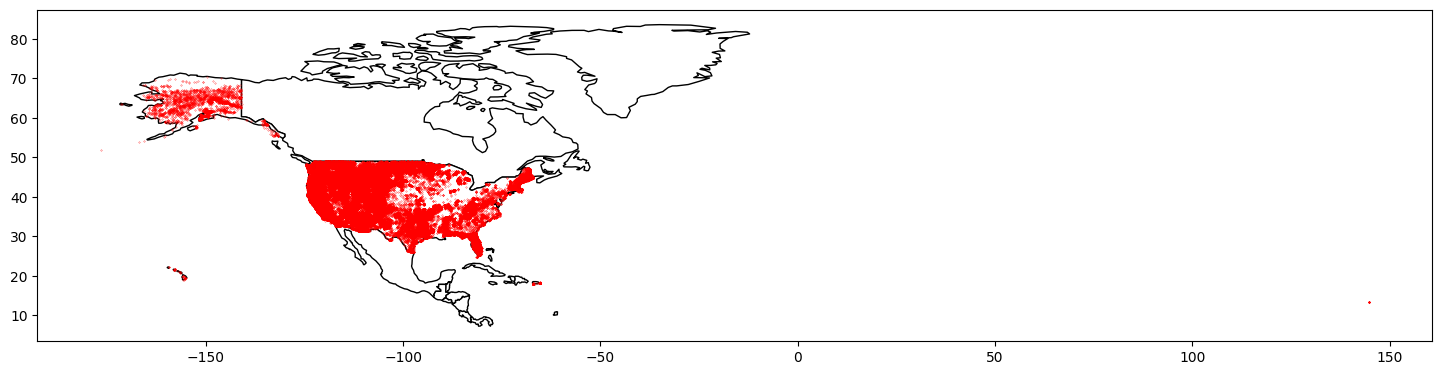

In [34]:
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['X'], df['Y'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black',figsize=(18, 12))
gdf.plot(ax = ax,marker='o', color='red', markersize=.05)

In [35]:
#Dataframes for different states
df.head()

,X,Y,OBJECTID,DiscoveryAcres,FireCause,FireDiscoveryDateTime,GACC,POOCounty,POOFips,POOState,geometry
0,-118.180712,33.808985,1,0.10,Unknown,2020/02/28 20:45:40+00,OSCC,Los Angeles,06037,US-CA,POINT (-118.18071 33.80898)
1,-117.153901,33.176394,2,NaN,NaN,2019/07/01 19:54:00+00,OSCC,San Diego,06073,US-CA,POINT (-117.15390 33.17639)
2,-121.104180,38.834727,3,NaN,NaN,2016/06/20 22:05:59+00,ONCC,Placer,06061,US-CA,POINT (-121.10418 38.83473)
3,-117.228592,33.782442,4,0.10,Undetermined,2021/11/25 15:17:32+00,OSCC,Riverside,06065,US-CA,POINT (-117.22859 33.78244)
4,-118.309032,33.941815,5,0.01,Undetermined,2022/11/21 11:25:33+00,OSCC,Los Angeles,06037,US-CA,POINT (-118.30903 33.94181)


In [36]:
df = df.sort_values(by = 'POOState')[36:]
df_states = []
for states in df.POOState.unique():
  df_states.append(df[df['POOState']==states])

In [37]:
def indx_state(st):  
  inp_st = 'US-' + st
  st_list = df.POOState.unique()
  return np.where(st_list == inp_st)[0][0]
indx_state('TX')

44

In [38]:
st = input('Which state do you want to look at? (Use the two letter version)')
try:
  wfire = df_states[indx_state(st)]
except:
  print('Try again. Use two letter State representation')

In [42]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=UserWarning)
    
    USmap = folium.Map(location=[30.622370, -96.325851], zoom_start=10, control_scale=True)
    feature_group = folium.FeatureGroup("Locations")
    marker_cluster = MarkerCluster().add_to(USmap)
    wfire['FireDiscoveryDateTime'] = pd.to_datetime(wfire['FireDiscoveryDateTime'])
    wfire['FireYear'] = pd.DatetimeIndex(wfire.FireDiscoveryDateTime).year
    wfire = wfire[wfire.FireYear>2015]
    for i in range(wfire.shape[0]):
        lat = wfire.iloc[i].Y
        lng = wfire.iloc[i].X
        Year = wfire.iloc[i].FireYear
        Month = wfire.iloc[i].FireDiscoveryDateTime.month
        Day = wfire.iloc[i].FireDiscoveryDateTime.day
        Area = wfire.iloc[i].DiscoveryAcres
        Cause = wfire.iloc[i].FireCause
        pop = 'Date=%d/%d/%d \n\n\n Area=%.2f \n\n\n  Cause = %s'%(Month, Day, Year,  Area,  Cause)
        folium.Marker(location=[lat,lng],popup= pop, radius = 2, color = '#e25822',
                        icon = folium.Icon(icon='fire', color= '#e25822')).add_to(marker_cluster)
    USmap.save(st+'.html')